In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
from time import sleep
from bs4 import BeautifulSoup as BS
from matplotlib import rcParams
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

random_seed = 52
np.random.seed(random_seed)
rcParams['figure.figsize'] = 11.7,8.27

In [2]:
info_weather = []

link_part_1, link_part_2 = "https://thermo.karelia.ru/weather/w_history.php?town=msk&month=", "&year="

try:
    for year in range(1949, 1996):
        for month in range(1, 13):
            url = link_part_1 + str(month) + link_part_2 + str(year)
            res = requests.get(url)
            soup = BS(res.text, "html.parser")
            for elem in soup.find_all(align="MIDDLE")[2:]:
                data = elem.find_all('div')
                if len(data) != 1:
                    date = data[1].text.split()[0] + '.' + str(month) + '.' + str(year)
                    min_ = data[2].text
                    mid_ = data[3].text
                    max_ = data[4].text
                    amount_of_rain = data[5].text
                    info_weather.append((date, min_, mid_, max_, amount_of_rain))
                
finally:
    print(res)
    print(url)
    print(info_weather[-1])

<Response [200]>
https://thermo.karelia.ru/weather/w_history.php?town=msk&month=12&year=1995
('31.12.1995', '-18.7', '-16.2', '-14.1', '0')


In [3]:
df = pd.DataFrame(data=info_weather, columns=['date', 'min_t', 'mid_t', 'max_t', 'amount_of_rain'])

In [4]:
df['date'] = df['date'].apply(lambda date: datetime.strptime(date, '%d.%m.%Y'))

In [5]:
df = df.astype({'min_t': 'float64', 
           'mid_t': 'float64',
           'max_t': 'float64',
           'amount_of_rain': 'float64'}, )

In [6]:
df.dtypes

date              datetime64[ns]
min_t                    float64
mid_t                    float64
max_t                    float64
amount_of_rain           float64
dtype: object

In [7]:
df.to_csv('weather_1949-1995_msk.csv', index=False)

**Получили некоторые данные о погоде и сохранили их в файл ```weather_1949-1995_msk.csv```**

In [8]:
round(df.describe(), 3)

,min_t,mid_t,max_t,amount_of_rain
count,17129.000,17129.000,17129.000,17129.000
mean,1.233,5.012,8.972,1.838
std,10.349,10.875,11.762,4.178
min,-38.100,-35.000,-32.300,0.000
25%,-5.300,-2.600,0.100,0.000
50%,1.900,5.200,8.800,0.100
75%,9.800,14.400,19.300,1.700
max,23.300,28.100,35.000,62.500


Попытемся установить даты аномальных значений и выяснить что произошло в эти дни

In [9]:
df.sort_values(by=['max_t'], ascending=False).head(10)

,date,min_t,mid_t,max_t,amount_of_rain
11886,1981-07-22,20.1,25.8,35.0,8.3
11894,1981-07-30,22.1,28.1,34.9,1.0
8632,1972-08-21,14.9,24.7,34.8,0.0
8587,1972-07-07,20.4,27.8,34.8,0.0
8623,1972-08-12,16.0,25.6,34.4,0.0
8634,1972-08-23,15.6,26.0,34.2,0.0
8622,1972-08-11,15.5,24.6,34.1,0.0
924,1951-07-14,19.4,27.0,34.1,0.0
8633,1972-08-22,18.3,26.9,34.0,0.0
927,1951-07-17,18.4,25.7,33.7,0.0


In [10]:
df.sort_values(by=['min_t']).head(10)

,date,min_t,mid_t,max_t,amount_of_rain
2586,1956-01-31,-38.1,-35.0,-32.3,0.0
10952,1978-12-31,-38.0,-34.0,-30.3,0.0
10951,1978-12-30,-37.2,-34.8,-29.4,0.0
374,1950-01-10,-36.8,-32.8,-28.4,0.2
2585,1956-01-30,-35.7,-33.0,-29.4,0.0
2591,1956-02-05,-35.2,-31.4,-27.2,0.7
2587,1956-02-01,-34.8,-27.0,-21.6,0.9
1496,1953-02-05,-33.3,-27.9,-21.8,0.0
10953,1979-01-01,-33.0,-28.2,-24.1,0.0
369,1950-01-05,-33.0,-30.3,-27.5,0.0


В эти дни в Москве действительно была [аномальная жара](https://tass.ru/info/11731797) и морозы

In [11]:
df.sort_values(by=['amount_of_rain'], ascending=False).head(10)

,date,min_t,mid_t,max_t,amount_of_rain
7834,1970-06-14,11.4,15.2,19.6,62.5
11871,1981-07-07,16.1,19.5,25.9,61.5
12989,1984-07-29,10.7,15.6,22.1,59.4
13652,1986-06-23,9.4,10.5,14.4,58.6
934,1951-07-24,11.9,13.8,15.5,58.3
15459,1991-06-06,13.1,16.8,22.9,58.2
10384,1977-06-11,17.1,19.4,24.1,53.8
3871,1959-08-08,16.1,19.8,27.2,53.0
12232,1982-07-03,14.9,16.2,17.8,50.2
8985,1973-08-09,17.0,19.0,24.8,49.6


А вот эти дни были [самые сильные ливни](https://russian7.ru/post/samyy-strashnyy-liven-v-istorii-moskv/)

In [12]:
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df.drop('date', inplace=True, axis=1)


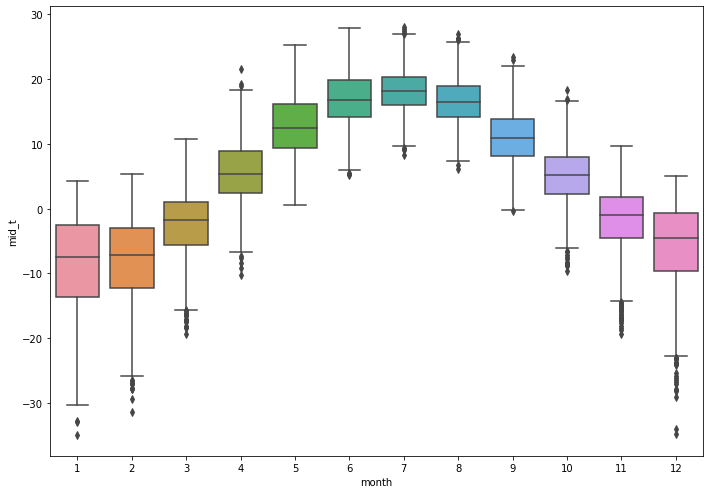

In [13]:
sns.boxplot(data=df, x="month", y= "mid_t")
plt.show()

Для анализа нам скорее всего не понадобятся переменные ```min_t``` и ```max_t```, а оставим ```mid_t``` и переименуем эту переменную в ```temperature```

In [14]:
df.drop(['min_t', 'max_t'], inplace=True, axis=1)
df.rename(columns={'mid_t': 'temperature'}, inplace=True)

In [15]:
q_l, q_h = .25, .75
columns_name = ['temperature', 'amount_of_rain']
for column_name in columns_name:
    q_low = df[column_name].quantile(q_l)
    q_high = df[column_name].quantile(q_h)
    q_range = q_high - q_low
    df = df[(df[column_name] < q_high + 1.5 * q_range) & (df[column_name] > q_low - 1.5 * q_range)]


In [16]:
df.corr()

,temperature,amount_of_rain,day,month
temperature,1.000000,-0.039949,0.002533,0.193769
amount_of_rain,-0.039949,1.000000,0.009316,0.011148
day,0.002533,0.009316,1.000000,0.008546
month,0.193769,0.011148,0.008546,1.000000


Очень слабая связь, но мы всё равно попытемся применить разные модели

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[::, 1:], df.iloc[::, 0], test_size=0.20, random_state=10)
reg = LinearRegression()
reg.fit(np.array(X_train).reshape(-1, 3), y_train)
print(r2_score(y_train,  reg.predict(np.array(X_train).reshape(-1, 3))))
print(r2_score(y_test,  reg.predict(np.array(X_test).reshape(-1, 3))))

0.0394257991683874
0.03855188282595767


Метрики получились отвратительные. Давайте сделаем полиномизацию признаков - возведение признаков в степени.

In [19]:
pipe = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
pipe.fit(np.array(X_train).reshape(-1, 3), y_train)
print(f"r2_train = {r2_score(y_train,  pipe.predict(np.array(X_train).reshape(-1, 3))):.4f}")
print(f"r2_test  = {r2_score(y_test,  pipe.predict(np.array(X_test).reshape(-1, 3))):.4f}")

r2_train = 0.8149
r2_test  = 0.8184


**Получили достаточно хорошую модель для предсказания температуры по кол-ву осадков, дне и месяце**